# Task Overview

Your task will be to implement a variant of *ProxyProp* (Proximal Backpropagation) – a modification of backpropagation in which the weights of the network are not updated according to gradient descent, but according to [proximal mapping operator](https://en.wikipedia.org/wiki/Proximal_operator). This proximal operator in many cases results in a descent that is quicker than in the case of traditional gradient descent. Interestingly enough, the proximal operator arose in the context of gradient descent in which the minimized function is not differentiable, and gradient descent cannot be applied directly as we cannot compute the Jacobi matrix. This method is called [proximal gradient method](https://en.wikipedia.org/wiki/Proximal_gradient_method). However, we are interested here in the efficiency of the approach rather than its robustness. The backpropagation method in the proximal approach (i.e. *ProxyProp* algorithm) is described in detail in [this paper](https://arxiv.org/pdf/1706.04638v3).

The original algorithm presented in the paper uses purely linear transformations between subsequent network layers. Part of your task is to use affine transformations there, i.e. ones with biases.

You should use an MLP architecture trained on the MNIST dataset. You should implement the network in numpy.

Tasks:
1. (9pt) Fill missing code below
  - 1pt implement the `__init__` method
  - 2pt implement the feedforward method
  - 6pt implement the backpropagation
2. Train the models (find proper hyperparameters). Visualize the learning speed of your best model compared with the standard backpropagation (plot training loss for subsequent numbers of epochs using both algorithms). Your model should reach at least 94% accuracy. Use ClearML to log your scores. Make a comparison of memory usage for _ProxProp_ network and the network you implemented in lab 3.
  - 1pt for accuracy above 94%
  - 1pt for initialization of the standard backpropagation and ProxyProp with the same random values
  - 1pt for visualizations (we recommend downloading plots from clear ml)
  - 2pt if [clear ml](https://clear.ml/docs/latest/docs/) used properly
  - 1pt for comparing memory usage.

Part of the assignment consists of deriving proper formulas for a proposed slight modification of _ProxProp_. We do not grant points separately for this activity. You are rewarded for that only after proper implementation.


## Potential questions, clarifications
- Q: Can I modify code of _ProxyProp_ outside #Your code goes here # to include logging?
  - Yes, in ProxyProp.SGD
- Q: Can I modify the code of _Network_ to include logging?
  - Yes.

In [1]:
%pip install clearml
%pip install memory-profiler
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from clearml import Logger
from typing import List

In [3]:
%load_ext memory_profiler

# Dataset loading


I used gdown instead of wget, becaue wget wasn't working in my IDE.

In [4]:
!wget -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

# !pip install --upgrade gdown
# !gdown -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Downloading...
From: https://s3.amazonaws.com/img-datasets/mnist.npz
To: C:\Users\Julek\PycharmProjects\pythonProject1\mnist.npz

  0%|          | 0.00/11.5M [00:00<?, ?B/s]
  5%|4         | 524k/11.5M [00:00<00:11, 965kB/s]
  9%|9         | 1.05M/11.5M [00:00<00:06, 1.65MB/s]
 14%|#3        | 1.57M/11.5M [00:00<00:04, 2.20MB/s]
 18%|#8        | 2.10M/11.5M [00:01<00:03, 2.41MB/s]
 27%|##7       | 3.15M/11.5M [00:01<00:02, 3.86MB/s]
 46%|####5     | 5.24M/11.5M [00:01<00:00, 7.00MB/s]
 55%|#####4    | 6.29M/11.5M [00:01<00:00, 7.41MB/s]
 68%|######8   | 7.86M/11.5M [00:01<00:00, 8.24MB/s]
 78%|#######7  | 8.91M/11.5M [00:01<00:00, 8.44MB/s]
 91%|#########1| 10.5M/11.5M [00:01<00:00, 8.88MB/s]
100%|##########| 11.5M/11.5M [00:01<00:00, 5.96MB/s]


In [5]:
def load_mnist(path: str = "mnist.npz"):
    with np.load(path) as f:
        x_train, _y_train = f["x_train"], f["y_train"]
        x_test, _y_test = f["x_test"], f["y_test"]

    x_train = x_train.reshape(-1, 28 * 28) / 255.0
    x_test = x_test.reshape(-1, 28 * 28) / 255.0

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = load_mnist()

# Set up clear ml

In [6]:
### Your code goes here ###

from clearml import Task

web_server = 'https://app.clear.ml'
api_server = 'https://api.clear.ml'
files_server = 'https://files.clear.ml'
access_key = 'secret_key = '
Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)



###########################

# A quick recap of the backpropagation model

## Forward pass

We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

To compute gradients, use the following formulas:

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial b^{(l)}} = \frac{\partial L}{\partial f^{(l)}}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial W^{(l)}} = \frac{\partial L}{\partial f^{(l)}} \cdot g^{(l-1)}
\nonumber
%\end{equation}
$$

$l = L, L-1, \ldots, 1$.

# Network definition (as in laboratory 3)


In [7]:
def sigmoid(z: np.ndarray) -> float:
    return 1.0 / (1.0 + np.exp(-z))


def logloss(
    x: np.ndarray,
    y: np.ndarray,
) -> float:
    return -(np.log(x) * y).sum() / y.shape[1]

In [8]:
class Network(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a) + b)
        return a

    def update_mini_batch(
        self,
        mini_batch: tuple[np.ndarray, np.ndarray],
        eta: float,
    ):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w, loss = self.backprop(mini_batch[0].T, mini_batch[1].T)
        self.weights = [
            w - (eta / len(mini_batch[0])) * nw for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - (eta / len(mini_batch[0])) * nb for b, nb in zip(self.biases, nabla_b)
        ]
        return loss

    def backprop(
        self,
        x: np.ndarray,
        y: np.ndarray,
    ) -> tuple[np.ndarray, np.ndarray, float]:
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g]  # list to store all the gs, layer by layer
        fs = []  # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g) + b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        loss = logloss(gs[-1], y)
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w, g in reversed(list(zip(self.weights, gs[1:]))):
            dLdf = np.multiply(dLdg, np.multiply(g, 1 - g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf, g.T) for dLdf, g in zip(reversed(dLdfs), gs[:-1])]
        dLdBs = [
            np.sum(dLdf, axis=1).reshape(dLdf.shape[0], 1) for dLdf in reversed(dLdfs)
        ]
        return (dLdBs, dLdWs, loss)

    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if logger is not None:
            logger.report_scalar(
                title="Loss", series="ProxyProp Loss", iteration=0, value=0
            )
            logger.report_scalar(
                title="Accuracy",
                series="ProxyProp Accuracy",
                iteration=0,
                value=0,
            )
        if test_data:
            x_test, y_test = test_data
        for j in range(epochs):
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            wloss = loss / (x_train.shape[0] // mini_batch_size)
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="ProxyProp Loss", iteration=j + 1, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="ProxyProp Accuracy",
                        iteration=j + 1,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))


# Simple check if all is fine
network = Network([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.7894, Loss: 1.4743628123429195
Epoch: 1, Accuracy: 0.8602, Loss: 0.6593879483209513


# The original ProxProp definition

Let us fix the notation for our network as in the following figure. We can see here a series of layers with $n_0,\ldots, n_{L-2}$ nodes. Each layer is composed of input nodes that depend linearly ($\phi$ operator) on the output nodes that depend non-linearly on the respective input nodes ($\sigma$ operator). The quality of the final output is measured by the final loss function ${\cal L}_y$ (typically $\frac{1}{2}\|\cdot\|^2$).




![image.png]( 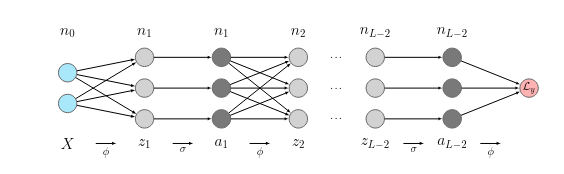)

_ProxProp_ procedure itself works similarly to a standard backpropagation procedure, as shown in the following figure.


![image.png]( 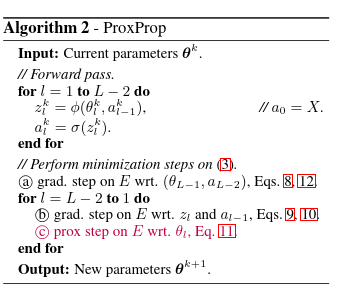)

For comparison, the standard backpropagation algorithm in this setting is as follows:


![image.png]( 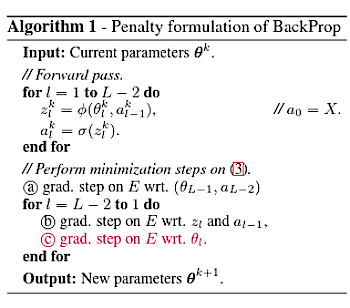)

Forward: The forward propagation phase is just as in the standard algorithm:

$z^k_l = \phi(\theta^k_l, a^k_{l−1}),$

$a^k_l = \sigma(z^k_l),$

where $\phi$ is supposed to be a linear transformation with weights $\theta^k_l$ over values $a^k_{l-1}$ and $\sigma$ is some non-linear step, e.g. the sigmoid function or the LeRU. You can use the sigmoid function for the purposes of this work.

Reverse: In the backpropagation, the step for the final layer ((a) on the figure) is exactly as in the gradient based version. In steps for the earlier layers, we recompute the z's and a's using the gradient method ((b) on the figure), but the weights are computed according to the proximal operator ((c) on the figure).

In step (a) the updated value is

$a'^{k}_{L−2} = a^k_{L−2} − \eta\nabla_{a_{L−2}} {\cal L}_y(\phi(\theta_{L−1}, a_{L−2})),$

where $\eta$ is the learning speed coefficient.

In case (b) the updated values are

$z'^{k}_l = z^k_l − \sigma'(z^k_l)(\sigma(z^k_l) − a'^k_l),$

$a'^{k}_{l−1} = a^k_{l−1} − \nabla( \frac{1}{2}\| \phi(θ^l, \cdot) − z'^k_l \|^2)(a^k_{l−1}),$

Note that the primed $a$-values are used to compute primed $z$-values and primed $z$-values are used to obtain the final value of $\theta^{k+1}$.

In case (c) the updated values are computed according to the proximal formula:

$$
\theta^{k+1}_l = \underset{\gamma}{\mathrm{argmin}} \left(\frac{1}{2} \|\phi(\gamma, a^k_{l−1}) − z'^k_l\|^2 + \frac{1}{2\tau_\theta}\|\gamma - \theta^k_l\|^2\right)
$$

The computation for the final layer is not done according to the proximity formula as it is difficult to obtain the closed formula for the necessary update, therefore it should be done according to the standard gradient descent.

The original formulas from the mentioned above paper do not use the biases. Part of the assignment is to rework this method so that the formulas include biases. You should develop a method in which biases are updated using the standard gradient descent method and the linear weight are updated using the _PropProx_ method with formulas adjusted to accommodate for biases.

# ProxProp similar to our backpropagation

Your task is to implement algorithm based on [ProxProp](https://arxiv.org/pdf/1706.04638v3). Please refer to the section above or section 4.2 in [the paper](https://arxiv.org/pdf/1706.04638v3) for algorithm description. Here we present the overview of the algorithm to be implemented.

## Forward pass

Forward pass is the same as in backpropagation implementation used in this course:
We begin with $g^{(0)} = x$.

To apply forward pass, use the following formulas L times:

$$
%\begin{equation}
f^{(l + 1)} = W^{(l+1)} g^{(l)} + b^{(l+1)}
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
g^{(l)} = \sigma(f^{(l)})
\nonumber
%\end{equation}
%\\
$$

$l = 1, 2, \ldots, L$.


Then, use output of the network is $g^{(L)}$ to compute the loss $L(y, g^{(L)})$.

## Backward pass

We begin with $\frac{\partial L}{\partial g^{(L)}}$, which can be computed directly.

Gradients $\frac{\partial L}{\partial f^{(l)}}$, $\frac{\partial L}{\partial g^{(l)}}$ need to be computed.

$$
%\begin{equation}
\frac{\partial L}{\partial f^{(l)}} = \frac{\partial L}{\partial g^{(l)}} \odot g^{(l)} \odot (1 - g^{(l)})
\nonumber
%\end{equation}
$$
$$
%\begin{equation}
\frac{\partial L}{\partial g^{(l)}} = (W^{(l+1)})^{T} \cdot \frac{\partial L}{\partial f^{(l+1)}}
\nonumber
%\end{equation}
$$

For simplicity, biases will be updated as in standard backpropagation:
$$
%\begin{equation}
b^{(l)} = b^{(l)} - \eta \frac{\partial L}{\partial b^{(l)}}
\nonumber
%\end{equation}
$$
Remember to make the gradient update independent from the batch size by appropriate averaging!

Weights will be updated using values $f^{(l)}_{*}, g^{(l)}_{*}$. They are defined as follows:

$$
%\begin{equation}
g^{(L)}_{*} = g^{(L)} - \eta \frac{\partial L}{\partial g^{(L)}}
%\end{equation}
$$

$$
%\begin{equation}
f^{(l)}_{*} = f^{(l)} - \frac{\partial g^{(l)}}{\partial f^{(l)}} \cdot (g^{(l)} - g^{(l)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

$$
%\begin{equation}
g^{(l)}_{*} = g^{(l)} - \frac{\partial f^{(l+1)}}{\partial g^{(l)}} \cdot (f^{(l+1)} - f^{(l+1)}_{*})
%\end{equation}
$$

$l = 1, 2, \ldots, L - 1$.

 The update of weights is defined as:

$$
%\begin{equation}
W^{(l)} = \text{arg min}_{W} \frac{1}{2} || W \cdot g^{(l-1)} + b^{(l)} - f^{(l)}_{*} ||^2 + \frac{1}{2\eta} || W - W^{(l)} ||^2
%\end{equation}
$$

$l = 1, 2, \ldots, L$.

Remarks:
* Weights are updated last (This means updated $b^{(l)}$ is used in the formula above).
* Please use closed form of the update assuming $W$ is a matrix. It might involve inverting some matrix. While it is not desirable in practice, the aim of this homework is to make you come up with the formula for the update :)
* Note that the original algorithm used two eta values. For the homework you should assume that these are equal and use for that only one parameter of the network.

In [9]:
class ProxProp(object):
    def __init__(
        self,
        sizes: List[int],
    ) -> None:
        self.sizes = sizes
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        # IMPORTANT: use at least one layer of size a -> a
        ### Your code goes here ###
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        ###########################

    def feedforward(
        self,
        a: np.ndarray,
    ) -> np.ndarray:
        # Run the network
        ### Your code goes here ###
        a = a.T
        for w, b in zip(self.weights, self.biases):
            a = sigmoid(np.dot(w, a) + b)
        return a
        ###########################

    def backprop(self, x: np.ndarray, y: np.ndarray, eta: float) -> float:

        ### Your code goes here ###

        first_layer = x
        layer_input = []        # Values of inputs before next layer.
        before_activation = []  # Values before using activation function.
        for w, b in zip(self.weights, self.biases):  # For every layer.
            x = np.dot(w, x) + b           # Use weights and biases.
            before_activation.append(x)    # Save before activation.
            x = sigmoid(x)                 # Use activation function.
            layer_input.append(x)          # Save current values.

        loss_val = logloss(x, y)  # Average loss between all images

        diff = self.cost_derivative(x, y)  # Derivative of loss function. (g^L at the beginning)
        g_star = layer_input[-1] - eta * diff  # Initial value of g* for last layer.

        for i in range(len(layer_input) - 1):
            curr_g = layer_input[-i - 1]        # Value of g for current layer.
            next_g = layer_input[-i - 2]        # Value of g for next layer.
            curr_f = before_activation[-i - 1]  # Value of f for current layer.
            curr_w = self.weights[-i - 1]       # Weights for current layer.
            sig_f = sigmoid(curr_f)             # Sigmoid of current f.


            derivative_sig = np.multiply(sig_f, np.subtract(np.ones(curr_g.shape), sig_f))  # Derivative of sigmoid(f).

            f_star = (curr_f - np.multiply(derivative_sig, np.subtract(curr_g, g_star)))  # Value of f* for current layer.

            diff = np.multiply(derivative_sig, diff)    # Calculating f^l for biases.
            self.biases[-i - 1] -= eta * diff.mean(axis=1).flatten().reshape(len(diff), 1)  # Updating new biases.
            diff = np.dot(self.weights[-i - 1].T, diff)  # Creating g^l-1 for biases.

            weights = np.dot(np.add(np.dot(np.subtract(f_star, self.biases[-i - 1]), next_g.T), np.multiply(1 / eta, curr_w)),
                      np.linalg.inv(np.add(np.dot(next_g, next_g.T), np.multiply(1/eta, np.identity(next_g.shape[0])))))
            self.weights[-i - 1] = weights  # Updating weight values for the layer.
            g_star = next_g - np.dot(curr_w.T, np.subtract(curr_f, f_star))  # Value of next g*.

        sig_f = sigmoid(before_activation[0])  # Sigmoid of last f.
        derivative_sig = np.multiply(sig_f, np.subtract(np.ones(layer_input[0].shape), sig_f))  # Derivative of sigmoid(f).
        f_star = (before_activation[0] - np.multiply(derivative_sig, np.subtract(layer_input[0], g_star)))  # Value of f* for the first layer.
        self.biases[0] -= eta * np.multiply(derivative_sig, diff).mean(axis=1).flatten().reshape(len(diff), 1)  # Updating first layer of biases.

        weights = np.dot(np.add(np.dot(np.subtract(f_star, self.biases[0]), first_layer.T), np.multiply(1 / eta, self.weights[0])),
                  np.linalg.inv(np.add(np.dot(first_layer, first_layer.T), np.multiply(1/eta, np.identity(first_layer.shape[0])))))
        self.weights[0] = weights  # Updating weight values for the layer.

        return loss_val
        ###########################


    def evaluate(
        self,
        test_data: tuple[np.ndarray, np.ndarray],
    ) -> float:
        pred = np.argmax(self.feedforward(test_data[0]), axis=0)
        corr = np.argmax(test_data[1], axis=1).T
        return np.mean(pred == corr)

    def cost_derivative(
        self,
        output_activations: np.ndarray,
        y: np.ndarray,
    ) -> np.ndarray:
        return output_activations - y

    def SGD(
        self,
        training_data: np.ndarray,
        epochs: int,
        mini_batch_size: int,
        eta: float,
        test_data: np.ndarray = None,
        logger: Logger = None,
    ) -> None:
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        wloss = logloss(self.feedforward(x_train).T, y_train) / (
            x_train.shape[0] // mini_batch_size
        )
        for j in range(epochs + 1):
            if logger is not None:
                logger.report_scalar(
                    title="Loss", series="ProxyProp Loss", iteration=j, value=wloss
                )
            if test_data:
                acc = self.evaluate((x_test, y_test))
                if logger is not None:
                    logger.report_scalar(
                        title="Accuracy",
                        series="ProxyProp Accuracy",
                        iteration=j,
                        value=acc,
                    )
                print("Epoch: {0}, Accuracy: {1}, Loss: {2}".format(j, acc, wloss))
            else:
                print("Epoch: {0}".format(j))
            if j == epochs:
                break
            loss = 0
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                y_mini_batch = y_train[
                    (mini_batch_size * i) : (mini_batch_size * (i + 1))
                ]
                loss += self.backprop(x_mini_batch.T, y_mini_batch.T, eta)
            wloss = loss / (
                x_train.shape[0] // mini_batch_size
            )  # we compute the average of the losses over the number of minibatches


# Simple check if all is fine
network = ProxProp([784, 30, 30, 10])
network.SGD(
    (x_train, y_train),
    epochs=2,
    mini_batch_size=100,
    eta=3.0,
    test_data=(x_test, y_test),
)

Epoch: 0, Accuracy: 0.0883, Loss: 18.76091035918351
Epoch: 1, Accuracy: 0.8613, Loss: 0.8214614691586142
Epoch: 2, Accuracy: 0.9014, Loss: 0.4314795953808743


Code visualizing accuracies and losses of models.

In [28]:
import pandas as pd
import plotly.express as px


# Visualizes accuracy and loss of models with matching 'tags'. Optionally assign the names.
def visualize(tags, names=None):
    task_list = Task.get_tasks(
        project_name='DNN_projekt1_moje_testy',
        tags=tags
    )  # Gather tasks
    
    # If there are no given names name models '1', '2', ...
    if names is None:
        names = [i for i in range(len(task_list))]
        
    data_acc = dict()   # Accuracies
    data_loss = dict()  # Losses
    
    # Gather data.
    for index, task in enumerate(task_list):
        metrics = task.get_reported_scalars()
        acc = metrics['Accuracy']['ProxyProp Accuracy']['y']
        loss = metrics['Loss']['ProxyProp Loss']['y']
        data_acc[names[index]] = pd.Series(acc, index=np.arange(len(acc)))
        data_loss[names[index]] = pd.Series(loss, index=np.arange(len(loss)))
        
    # Plot accuracies.
    fig = px.line(pd.DataFrame(data_acc),
                  labels={'index': 'Epochs',
                          'value': 'Accuracy [%]',
                          'variable': 'Experiment'},
                  title='Test accuracy')
    fig.show()
    
    # Polt losses.
    fig = px.line(pd.DataFrame(data_loss),
              labels={'index': 'Epochs',
                      'value': 'Loss',
                      'variable': 'Experiment'},
              title='Test loss')
    fig.show()


# Train the network

The process of training took over 70 trained models.

In [29]:
visualize(['exist'])  # Plot all models.

During training, I observed that models generally benefit from a larger learning rate. For instance, I experimented with a learning rate of 0.1, but the results were not as satisfactory as expected.

I decided to experiment with larger learning rates, going up to a maximum of 10. The models achieved the best accuracies with learning rates between 5 and 8, prompting me to investigate further. Ultimately, I found that learning rates in the range of 7 to 7.5 performed slightly better, so I settled on 7 as the optimal choice.

For the batch size, I discovered that models with larger values (e.g., 200) performed worse compared to those with smaller batch sizes. After testing various options, I found the best results occurred with batch sizes between 70 and 90, so I selected 80 as the optimal value.

For the architecture, I experimented with different models using two hidden layers of equal size. My primary goal was to ensure the network performed accurately, so the layer size couldn’t be too small. At the same time, I wanted the model to train quickly, allowing me to test multiple configurations efficiently. After training various sizes, I found 132 to be the optimal choice, balancing accuracy and speed.

# 5 models slightly better than the rest.

In [35]:
visualize(['TOP5'], names=["lr = 7, batch = 90", "lr = 7.25, batch = 90", "lr = 7, batch = 80", "lr = 7.25, batch = 70", "lr = 7.5, batch = 70"])

Each of these five models is well-designed, but I chose the one with a learning rate of 7 and a batch size of 80. This model stood out as the most stable across varying weights and biases among the five.

# Final model

I trained 5 best models with the same hyperparameters, different weights and biases.

In [15]:
### Your code goes here ###

# Parameters for the best Proxprop model.
params = {"structure": [784, 132, 132, 10], "learning_rate": 7, "batch_size": 80, "epochs": 20}


for i in range(5):
    task = Task.create(project_name='DNN_projekt1_moje_testy', task_name="Final net " + str(i + 1))
    task.mark_started()
    logger = task.get_logger()
    task.connect(params)


    network = ProxProp(params['structure'])
    network.SGD(
        (x_train, y_train),
        epochs=params['epochs'],
        mini_batch_size=params['batch_size'],
        eta=params['learning_rate'],
        test_data=(x_test, y_test),
        logger=logger
    )
    task.mark_completed()
    task.close()
###########################

Epoch: 0, Accuracy: 0.1008, Loss: 26.174662328225352
Epoch: 1, Accuracy: 0.1186, Loss: 0.682991151171573
Epoch: 2, Accuracy: 0.9262, Loss: 0.4484778552671439
Epoch: 3, Accuracy: 0.938, Loss: 0.35945946583886906
Epoch: 4, Accuracy: 0.9432, Loss: 0.2846441953238845
Epoch: 5, Accuracy: 0.9451, Loss: 0.244059667289687
Epoch: 6, Accuracy: 0.946, Loss: 0.21695353404727852
Epoch: 7, Accuracy: 0.9495, Loss: 0.19239173031974433
Epoch: 8, Accuracy: 0.9522, Loss: 0.17744239332229061
Epoch: 9, Accuracy: 0.9517, Loss: 0.16429179786790576
Epoch: 10, Accuracy: 0.9508, Loss: 0.1525863961521364
Epoch: 11, Accuracy: 0.9502, Loss: 0.1466160986056552
Epoch: 12, Accuracy: 0.9528, Loss: 0.13783791311872948
Epoch: 13, Accuracy: 0.952, Loss: 0.1317879513312733
Epoch: 14, Accuracy: 0.9526, Loss: 0.126572961332525
Epoch: 15, Accuracy: 0.9537, Loss: 0.1203988884062331
Epoch: 16, Accuracy: 0.9536, Loss: 0.11475299032144798
Epoch: 17, Accuracy: 0.9533, Loss: 0.11077430476435304
Epoch: 18, Accuracy: 0.9529, Loss: 0

Results:

In [36]:
visualize(['final'])

# Comparison of the best ProxProp and Backprop

I trained both ProxProp and BackProp on the same hyperparameters to see the outcome.

In [10]:
# Parameters for both models.
params = {"structure": [784, 132, 132, 10], "learning_rate": 7, "batch_size": 80, "epochs": 20}


task = Task.create(project_name='DNN_projekt1_moje_testy', task_name="Porównanie Prox")
task.mark_started()
logger = task.get_logger()
task.connect(params)

np.random.seed(0)  # Setting the first seed to prevent completely random initialization.
network = ProxProp(params['structure']) # Initialization of the best ProxProp model.
network.SGD(
    (x_train, y_train),
    epochs=params['epochs'],
    mini_batch_size=params['batch_size'],
    eta=params['learning_rate'],
    test_data=(x_test, y_test),
    logger=logger
)

task.mark_completed()
task.close()



task = Task.create(project_name='DNN_projekt1_moje_testy', task_name="Porównanie Backprop")
task.mark_started()
logger = task.get_logger()
task.connect(params)


np.random.seed(0)  # Setting the first seed to prevent completely random initialization.
network = Network(params['structure'])
network.SGD(
    (x_train, y_train),
    epochs=params['epochs'],
    mini_batch_size=params['batch_size'],
    eta=params['learning_rate'],
    test_data=(x_test, y_test),
    logger=logger
)

task.mark_completed()
task.close()

Epoch: 0, Accuracy: 0.0777, Loss: 29.62529840185619
Epoch: 1, Accuracy: 0.9064, Loss: 1.6621938324646939
Epoch: 2, Accuracy: 0.9315, Loss: 0.44638671586039125
Epoch: 3, Accuracy: 0.9424, Loss: 0.3405253150033578
Epoch: 4, Accuracy: 0.9466, Loss: 0.276209869920565
Epoch: 5, Accuracy: 0.948, Loss: 0.24002799834735192
Epoch: 6, Accuracy: 0.9484, Loss: 0.2118596541153863
Epoch: 7, Accuracy: 0.9517, Loss: 0.19195326259817183
Epoch: 8, Accuracy: 0.9486, Loss: 0.1757985980296938
Epoch: 9, Accuracy: 0.95, Loss: 0.16444730184469392
Epoch: 10, Accuracy: 0.9508, Loss: 0.15220281568263472
Epoch: 11, Accuracy: 0.9512, Loss: 0.1423239539288379
Epoch: 12, Accuracy: 0.9528, Loss: 0.13380307651320797
Epoch: 13, Accuracy: 0.9539, Loss: 0.1252442185627994
Epoch: 14, Accuracy: 0.9531, Loss: 0.1201359498055823
Epoch: 15, Accuracy: 0.9537, Loss: 0.11580124014509456
Epoch: 16, Accuracy: 0.9551, Loss: 0.11265579018403082
Epoch: 17, Accuracy: 0.9531, Loss: 0.1098768039171592
Epoch: 18, Accuracy: 0.9537, Loss: 

Unfortunately, Backprop's performance was significantly worse. As a result, I decided to compare it against ProxProp using the previously mentioned parameters.

In [11]:
params = {"structure": [784, 30, 30, 10], "learning_rate": 3, "batch_size": 100, "epochs": 20}

task = Task.create(project_name='DNN_projekt1_moje_testy', task_name="Porównanie Backprop - base params")
task.mark_started()
logger = task.get_logger()
task.connect(params)


np.random.seed(0)  # Setting the first seed to prevent completely random initialization.
network = Network(params['structure'])
network.SGD(
    (x_train, y_train),
    epochs=params['epochs'],
    mini_batch_size=params['batch_size'],
    eta=params['learning_rate'],
    test_data=(x_test, y_test),
    logger=logger
)

task.mark_completed()
task.close()

Epoch: 0, Accuracy: 0.6907, Loss: 2.010767895683771
Epoch: 1, Accuracy: 0.8502, Loss: 0.6889222998884766
Epoch: 2, Accuracy: 0.8832, Loss: 0.5202733163446179
Epoch: 3, Accuracy: 0.8961, Loss: 0.45132825267606524
Epoch: 4, Accuracy: 0.904, Loss: 0.40924814660514347
Epoch: 5, Accuracy: 0.9095, Loss: 0.3809453565601423
Epoch: 6, Accuracy: 0.9147, Loss: 0.35998288789526645
Epoch: 7, Accuracy: 0.9189, Loss: 0.3434453293256434
Epoch: 8, Accuracy: 0.9209, Loss: 0.32959475324146
Epoch: 9, Accuracy: 0.9234, Loss: 0.3174356131600883
Epoch: 10, Accuracy: 0.9257, Loss: 0.30655162568970795
Epoch: 11, Accuracy: 0.9275, Loss: 0.29708138338294005
Epoch: 12, Accuracy: 0.9298, Loss: 0.2891009311837406
Epoch: 13, Accuracy: 0.9305, Loss: 0.28228312418430207
Epoch: 14, Accuracy: 0.932, Loss: 0.27620439025177307
Epoch: 15, Accuracy: 0.9324, Loss: 0.2706353997313389
Epoch: 16, Accuracy: 0.9328, Loss: 0.26539926725400337
Epoch: 17, Accuracy: 0.934, Loss: 0.2604480958440888
Epoch: 18, Accuracy: 0.935, Loss: 0.

# Training plots for the best training

In [34]:
visualize(['Compare'], names=["Best ProxProp", "BackProp with parameters of best ProxProp", "BackProp with basic parameters"])

As shown in the chart, ProxProp's accuracy is approximately 2% better than the highest-performing Backprop model. Additionally, ProxProp exhibits a lower loss, though the rate of decrease is similar to that of Backprop.. Of course, if I were to fine-tune Backprop's parameters further, its performance could potentially improve.

 # Compare memory usage

Hint: you can use memory-profiler library [link](https://pypi.org/project/memory-profiler/)

In [11]:
### Your code goes here ###
def backprop():
    np.random.seed(0)  # Setting the first seed to prevent completely random initialization.
    network = Network([784, 1500, 1500, 10])
    network.SGD(
    (x_train, y_train),
    epochs=3,
    mini_batch_size=100,
    eta=3,
    test_data=(x_test, y_test),
)



def prox():
    np.random.seed(0)  # Setting the first seed to prevent completely random initialization.
    network = ProxProp([784, 1500, 1500, 10])
    network.SGD(
    (x_train, y_train),
    epochs=3,
    mini_batch_size=100,
    eta=3,
    test_data=(x_test, y_test),
)

%memit backprop()
%memit prox()
###########################

Epoch: 0, Accuracy: 0.1533, Loss: 45.24915397191177
Epoch: 1, Accuracy: 0.2238, Loss: 45.33747042204751
Epoch: 2, Accuracy: 0.2417, Loss: 42.56301545923121
peak memory: 1004.13 MiB, increment: 464.89 MiB
Epoch: 0, Accuracy: 0.0845, Loss: 114.88094889217919
Epoch: 1, Accuracy: 0.6823, Loss: 10.443647534052138
Epoch: 2, Accuracy: 0.7684, Loss: 8.146408774674956
Epoch: 3, Accuracy: 0.7998, Loss: 6.752139393115148
peak memory: 3268.60 MiB, increment: 2729.03 MiB


When measuring memory usage, I used larger hidden layer sizes to ensure consistent results, as smaller sizes exhibited more random behavior. As shown earlier, the increment in memory usage for ProxProp is six times higher than for BackProp. This is likely due to the matrix inversion process in ProxProp.